# Load DataFrames

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import matplotlib.pyplot as plt

path_root = "/Spring2020_VisualAnalytics/output/"

df_academies = pd.read_csv(os.path.join(path_root, "academies.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_aristo_title = pd.read_csv(os.path.join(path_root, "aristo_title.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_egonetworkscombined = pd.read_csv(os.path.join(path_root, "egonetworkscombined.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_knowledge_network = pd.read_csv(os.path.join(path_root, "knowledge_network.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
# df_main = pd.read_csv(os.path.join(path_root, "main.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_military_rank = pd.read_csv(os.path.join(path_root, "military_rank.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_nationality = pd.read_csv(os.path.join(path_root, "nationality.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_occupation = pd.read_csv(os.path.join(path_root, "occupation.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_political_rank = pd.read_csv(os.path.join(path_root, "political_rank.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_professional_network = pd.read_csv(os.path.join(path_root, "professional_network.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_salons = pd.read_csv(os.path.join(path_root, "salons.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_social_network = pd.read_csv(os.path.join(path_root, "social_network.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_source = pd.read_csv(os.path.join(path_root, "source.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")

df_raw = pd.read_csv("salons_project_raw_data.tsv", index_col="SP ID", sep='\t', encoding = "ISO-8859-1")

In [5]:
from itertools import combinations

def create_pandas_edgelist(input_df, column):

    df = pd.DataFrame(columns=["Source","Target"])
    
    for index in range(0, input_df.shape[0]):
        df_temp = pd.DataFrame(columns=["Source","Target"])
        
        comma_sep_value = [i.strip() for i in input_df[column].values[index].split(",")]
        if len(comma_sep_value) == 1:
            df_temp.loc[len(df_temp)] = comma_sep_value * 2
        else:
            comma_sep_value = list(combinations(comma_sep_value, 2))
            df_temp = pd.DataFrame(comma_sep_value, columns=["Source","Target"])
        df = df.append(df_temp, ignore_index=True)

    return df

df_edgelist = create_pandas_edgelist(input_df=df_raw, column="EgoNetworksCombined")
df_edgelist = df_edgelist.groupby(['Source','Target']).size().reset_index()
df_edgelist = df_edgelist.rename({0: "Counts"}, axis=1)

In [7]:
df_edgelist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 3 columns):
Source    433 non-null object
Target    433 non-null object
Counts    433 non-null int64
dtypes: int64(1), object(2)
memory usage: 10.3+ KB


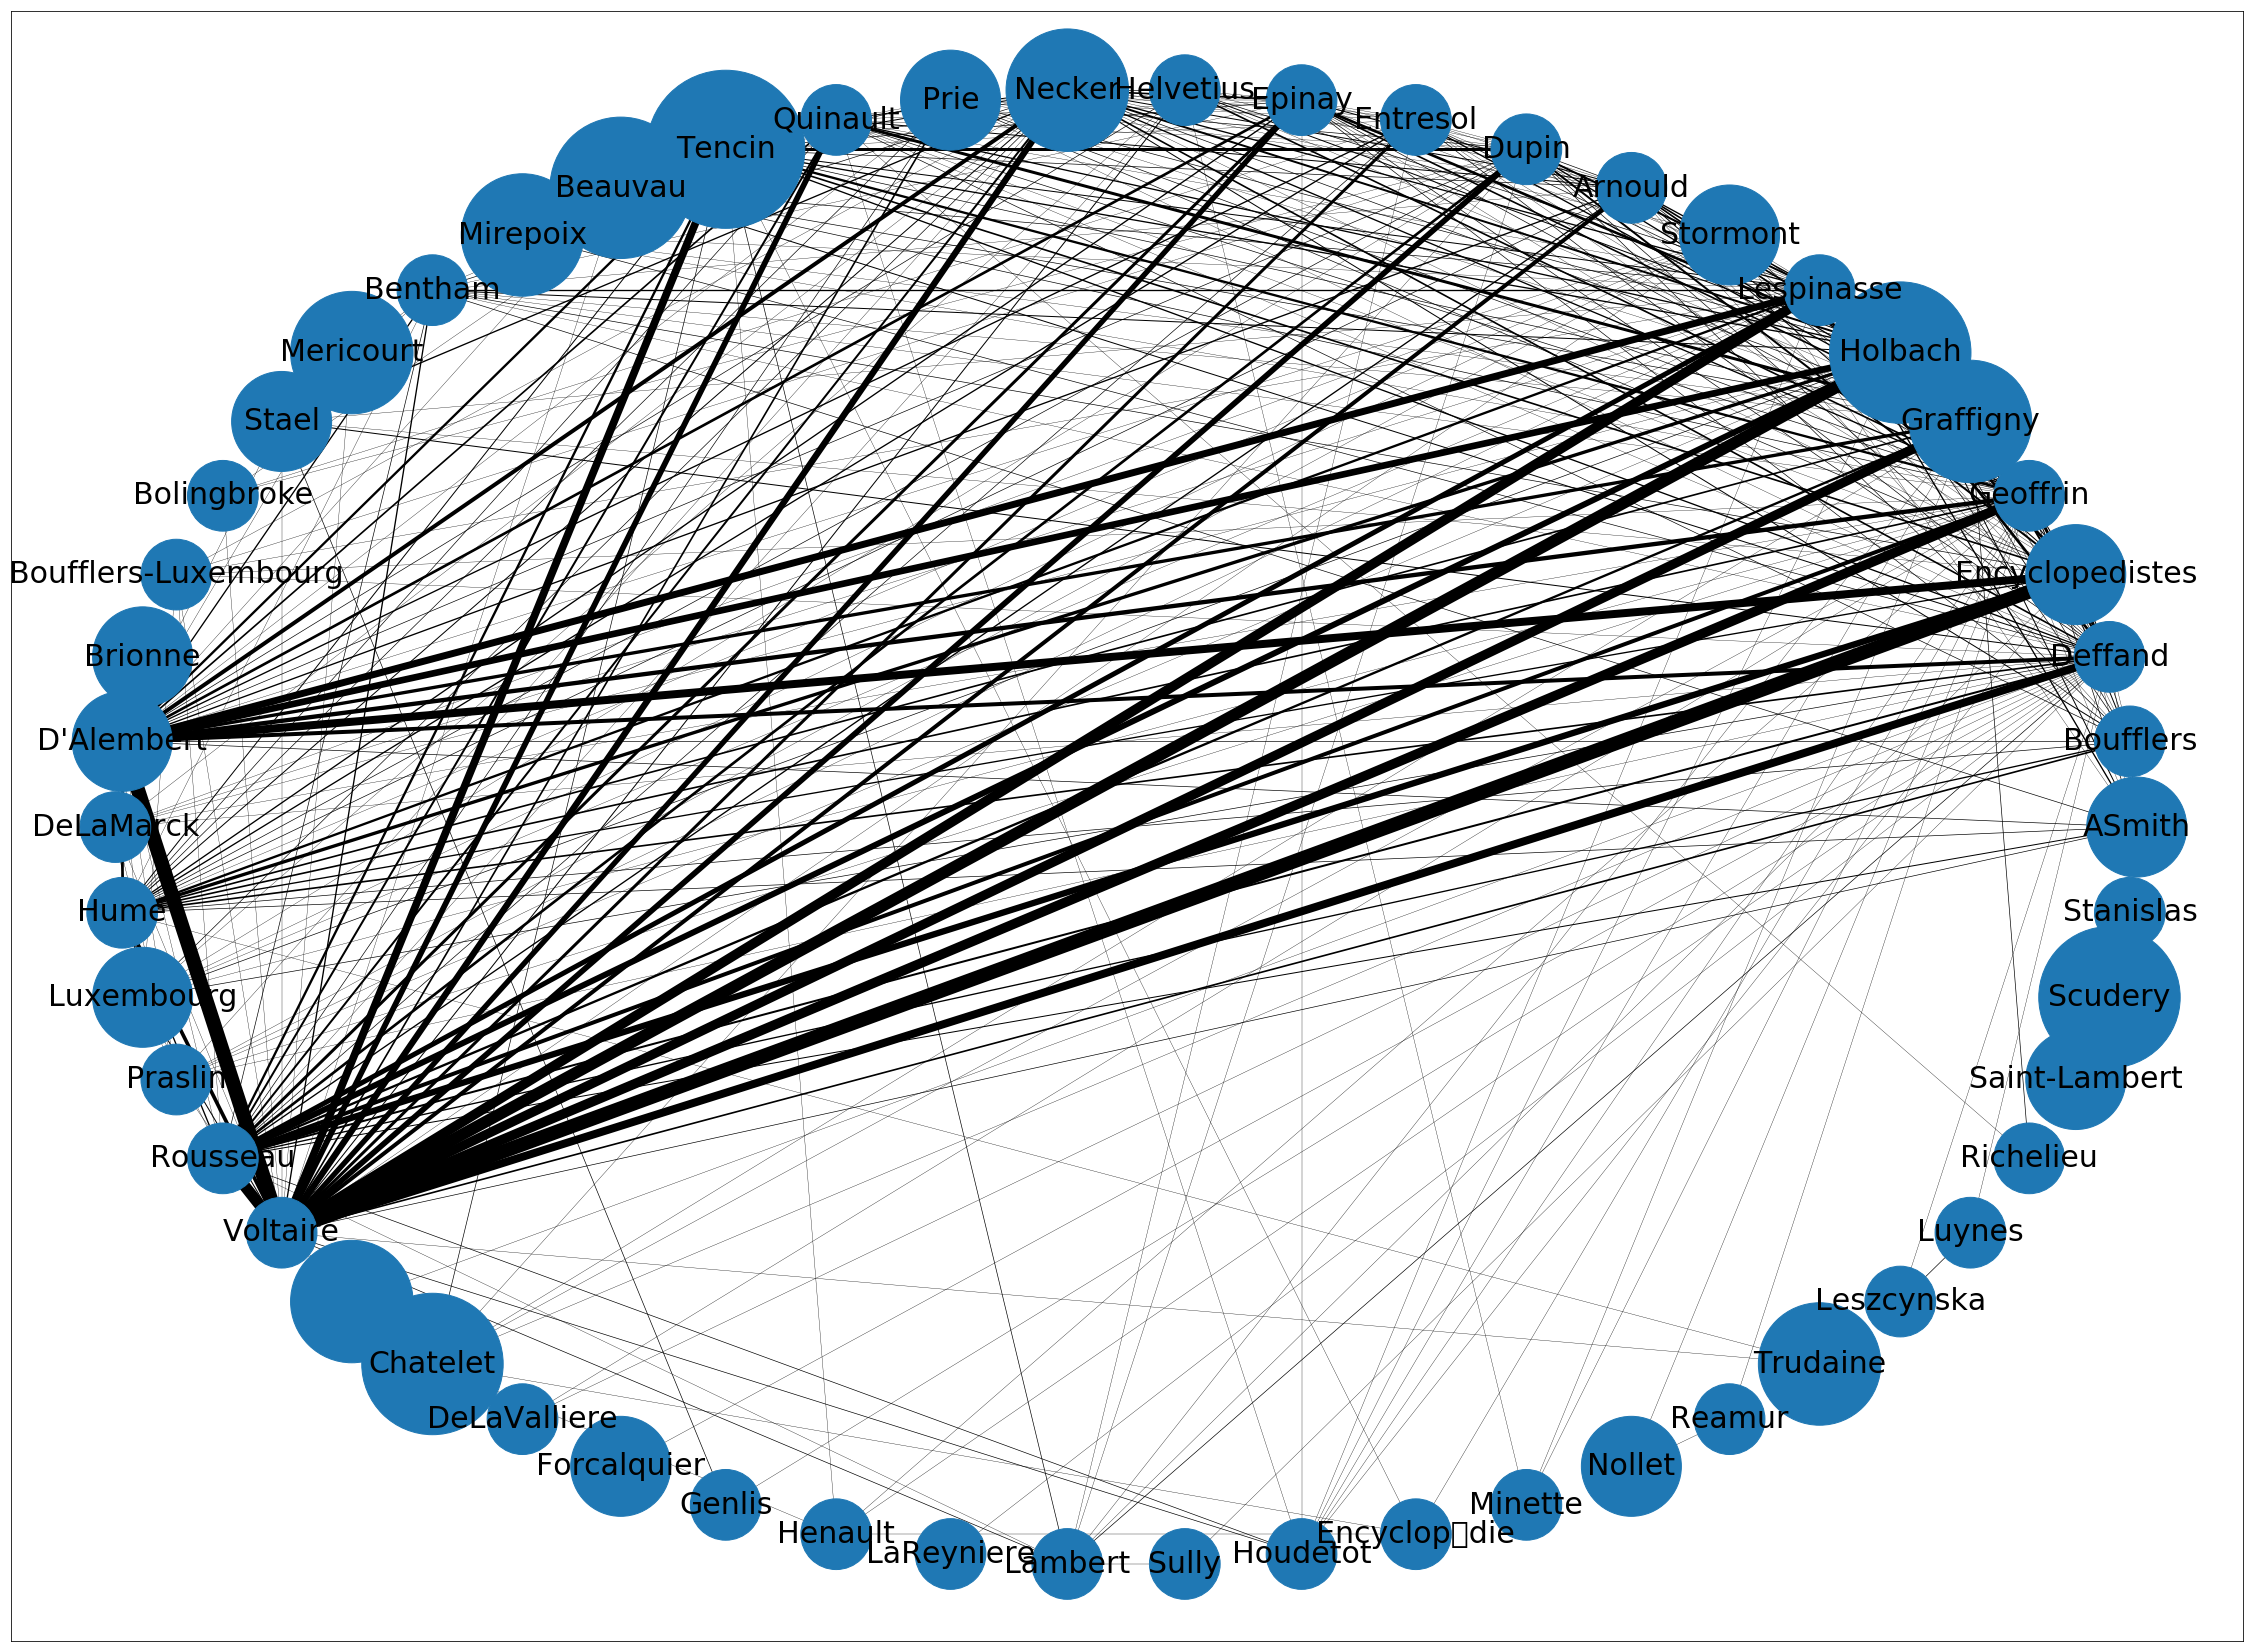

In [32]:
G = nx.from_pandas_edgelist(
    df=df_edgelist,
    source="Source",
    target="Target",
    edge_attr="Counts"
)
durations = [i['Counts'] for i in dict(G.edges).values()]
durations = np.array(durations) / 3
# durations = np.log1p(durations)
# durations = np.log(durations)

labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

fig, ax = plt.subplots(figsize=(40,30))
pos = nx.circular_layout(G, scale=5)
# pos = nx.kamada_kawai_layout(G, scale=5)

nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,
    node_size=df_edgelist["Counts"].values * 5000
)
nx.draw_networkx_edges(G, pos, width=durations, ax=ax)
_ = nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=30)

# Network demo

In [2]:
df_combo = df_salons.merge(df_social_network, left_index=True, right_index=True, how="outer")
df_combo = df_combo.groupby(['Salons','Social Network']).size().reset_index()
df_combo = df_combo.rename({0: "Counts"}, axis=1)

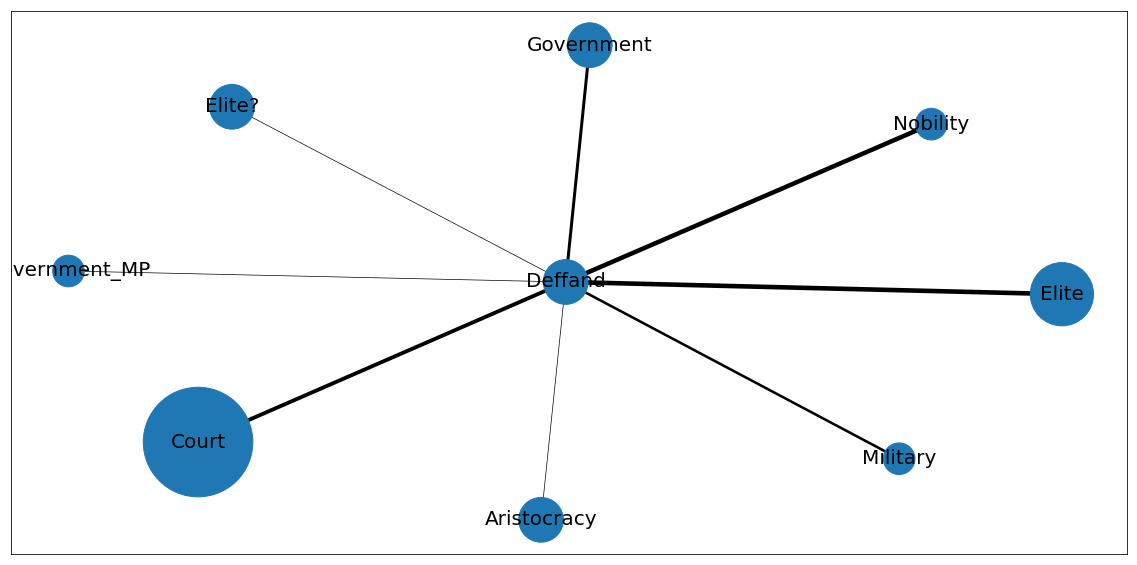

In [3]:
G = nx.from_pandas_edgelist(
#     df=df_combo[df_combo["Social Network"] == "Government"],
    df=df_combo[df_combo["Salons"] == "Deffand"],
#     df=df_combo,
    source="Salons",
    target="Social Network",
    edge_attr="Counts"
)
durations = [i['Counts'] for i in dict(G.edges).values()]
durations = np.log1p(durations)
labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

fig, ax = plt.subplots(figsize=(20,10))
pos = nx.spring_layout(G, scale=1)
nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,
    node_size=df_combo["Counts"].values * 1000
)
nx.draw_networkx_edges(G, pos, width=durations, ax=ax)
_ = nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=20)

# Review DataFrames & Basic Visualizations

In [ ]:
def category_prob_barh(df, column, other_threshold=0.02):
    # set figure size and facecolor
    plt.rcParams["figure.figsize"] = (20,12)
    plt.rcParams['axes.facecolor'] = 'ffffff'
    plt.rcParams["figure.facecolor"] = 'ffffff'
    
    prob = df[column].value_counts(normalize=True)
    threshold = other_threshold
    mask = prob > threshold
    tail_prob = prob.loc[~mask].sum()
    prob = prob.loc[mask]
    prob['other'] = tail_prob
    prob[::-1].plot(kind='barh')
    plt.xticks(rotation=0, size=20)
    plt.yticks(size=20)

    plt.show()
    
def category_count_barh(df, column, top_n):
    df[column].value_counts()[:top_n].plot(kind='barh', fontsize=20).invert_yaxis()

## Main

In [ ]:
df_main.info()
display(df_main.head(10))

## Academies

In [ ]:
df_academies.info()
display(df_academies.head(10))

In [ ]:
category_prob_barh(df=df_academies, column="Academies")

In [ ]:
category_count_barh(df=df_academies, column="Academies", top_n=10)

## Aristocracy title

In [ ]:
df_aristo_title.info()
display(df_aristo_title.head(10))

In [ ]:
category_prob_barh(df=df_aristo_title, column="Aristo title")

In [ ]:
category_count_barh(df=df_aristo_title, column="Aristo title", top_n=10)

## Ego networks combined

In [ ]:
df_egonetworkscombined.info()
display(df_egonetworkscombined.head(10))

In [ ]:
category_prob_barh(df=df_egonetworkscombined, column="EgoNetworksCombined")

In [ ]:
category_count_barh(df=df_egonetworkscombined, column="EgoNetworksCombined", top_n=10)

## Knowledge network

In [ ]:
df_knowledge_network.info()
display(df_knowledge_network.head(10))

In [ ]:
category_prob_barh(df=df_knowledge_network, column="Knowledge Network")

In [ ]:
category_count_barh(df=df_knowledge_network, column="Knowledge Network", top_n=10)

## Military rank

In [ ]:
df_military_rank.info()
display(df_military_rank.head(10))

In [ ]:
category_prob_barh(df=df_military_rank, column="Military rank")

In [ ]:
category_count_barh(df=df_military_rank, column="Military rank", top_n=10)

## Nationality

In [ ]:
df_nationality.info()
display(df_nationality.head(10))

In [ ]:
category_prob_barh(df=df_nationality, column="Nationality")

In [ ]:
category_count_barh(df=df_nationality, column="Nationality", top_n=10)

## Occupation

In [ ]:
df_occupation.info()
display(df_occupation.head(10))

In [ ]:
category_prob_barh(df=df_occupation, column="Occupation")

In [ ]:
category_count_barh(df=df_occupation, column="Occupation", top_n=10)

## Political rank

In [ ]:
df_political_rank.info()
display(df_political_rank.head(10))

In [ ]:
category_prob_barh(df=df_political_rank, column="Political rank")

In [ ]:
category_count_barh(df=df_political_rank, column="Political rank", top_n=10)

## Professional network

In [ ]:
df_professional_network.info()
display(df_professional_network.head(10))

In [ ]:
category_prob_barh(df=df_professional_network, column="Professional Network")

In [ ]:
category_count_barh(df=df_professional_network, column="Professional Network", top_n=10)

## Salons

In [ ]:
df_salons.info()
display(df_salons.head(10))

In [ ]:
category_prob_barh(df=df_salons, column="Salons")

In [ ]:
category_count_barh(df=df_salons, column="Salons", top_n=10)

## Social network

In [ ]:
df_social_network.info()
display(df_social_network.head(10))

In [ ]:
category_prob_barh(df=df_social_network, column="Social Network")

In [ ]:
category_count_barh(df=df_social_network, column="Social Network", top_n=10)

## Source

In [ ]:
df_source.info()
display(df_source.head(10))

In [ ]:
category_prob_barh(df=df_source, column="Source")

In [ ]:
category_count_barh(df=df_source, column="Source", top_n=10)